# Cross correlation of DTOCs and ED Breaches

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_dtoc = pd.read_csv('dtoc.csv')
df_dtoc.shape

(80, 10)

In [3]:
df_dtoc.head()

,year,month,total_atten,total_atten_t1,total_atten_>4hr,95%_targ,total_admissions,dtoc_a,dtoc_na,dtoc_total
0,2010-11,August,1719197.000,1138652.000,33184.00000,0.980698,425702.0000,2559,2381,4940
1,2010-11,September,1715117.000,1150728.000,41151.00000,0.976007,424900.0000,2647,2357,5004
2,2010-11,October,1753934.000,1163143.000,47414.00000,0.972967,436215.0000,2513,2075,4588
3,2010-11,November,1604591.000,1111294.571,46436.42857,0.971060,429099.0000,2352,2057,4409
4,2010-11,December,1647823.857,1159203.857,89917.28571,0.945433,452728.7143,1995,1866,3861


In [4]:
df_dtoc.rename(columns={'total_atten_>4hr':'total_breaches'},inplace=True)

dickey fuller test of stationarity

Notes: both are ns - this means that they are non-stationary

In [5]:
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [6]:
check_stationarity(df_dtoc['total_breaches'])

ADF Statistic: -1.529597
p-value: 0.518823
	5%: -2.899
	10%: -2.587
	1%: -3.516


In [7]:
check_stationarity(df_dtoc['dtoc_total'])

ADF Statistic: 0.603833
p-value: 0.987710
	5%: -2.906
	10%: -2.590
	1%: -3.532


Difference time series

In [8]:
df_dtoc.columns

Index(['year', 'month', 'total_atten', 'total_atten_t1', 'total_breaches',
       '95%_targ', 'total_admissions', 'dtoc_a', 'dtoc_na', 'dtoc_total'],
      dtype='object')

In [9]:
df_dtoc['total_breaches_diff'] = df_dtoc['total_breaches'].diff()
df_dtoc['dtoc_total_diff'] = df_dtoc['dtoc_total'].diff()
df_dtoc['total_admissions_diff'] = df_dtoc['total_admissions'].diff()
df_dtoc['total_atten_diff'] = df_dtoc['total_atten'].diff()

In [10]:
# drop lost row
df_dtoc.dropna(inplace=True)

In [11]:
check_stationarity(df_dtoc.total_breaches_diff.loc[df_dtoc.total_breaches_diff.index > 0])

ADF Statistic: -3.591030
p-value: 0.005935
	5%: -2.904
	10%: -2.590
	1%: -3.529


In [12]:
check_stationarity(df_dtoc.dtoc_total_diff.loc[df_dtoc.dtoc_total_diff.index > 0])

ADF Statistic: -1.538870
p-value: 0.514203
	5%: -2.906
	10%: -2.590
	1%: -3.532


Still non-stationary!

Cross correlation

In [13]:
def bk_cov(df1,df2):
    'calc cov from two series'
    X = df1.values
    Xm = df1.values.sum()/len(X)
    Y = df2.values
    Ym = df2.values.sum()/len(Y)
    cov = ( ((X-Xm)*(Y-Ym))/len(Y)).sum()
    return(cov)

In [14]:
def bk_cor(df1,df2):
    'cal corr'
    cor = bk_cov(df1,df2)/np.sqrt(bk_cov(df1,df1) * bk_cov(df2,df2))
    return cor

In [15]:
def bk_crosscorr(df1,df2,lag=0):
    return bk_cor(df1[lag:],df2.shift(lag)[lag:])

In [16]:
def calc_crosscorr(df,col1,col2,lags):
    'calc various cross corr on df with range of lags'
    corrs = [bk_crosscorr(df[col1], df[col2], lag=i) for i in range(lags)]
    return corrs

In [17]:
cross_corr_scores = pd.DataFrame()

In [18]:
def compute_crosscorr_mult_inputs(df,yvar,xvars,lags,title=''):
    ''' make df with lagged cross corrs for multiple vars'''
    
    cross_corr_scores = pd.DataFrame()
    for i in xvars:
        corrs = calc_crosscorr(df,yvar,i,lags)
        cross_corr_scores[i] = corrs
    ax = plt.subplot()
    cross_corr_scores.plot(ax=ax)
    ax.set_ylabel('cross-corr coef')
    ax.set_xlabel('lags (months)')
    ax.set_title(title)
    return

In [19]:
df_dtoc.columns

Index(['year', 'month', 'total_atten', 'total_atten_t1', 'total_breaches',
       '95%_targ', 'total_admissions', 'dtoc_a', 'dtoc_na', 'dtoc_total',
       'total_breaches_diff', 'dtoc_total_diff', 'total_admissions_diff',
       'total_atten_diff'],
      dtype='object')

cross correlation coeff for various lags for undifferenced

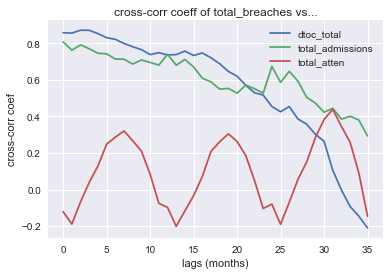

In [20]:
xvars = ['dtoc_total','total_admissions','total_atten']
compute_crosscorr_mult_inputs(df_dtoc,'total_breaches',xvars,36,title ='cross-corr coeff of total_breaches vs...')

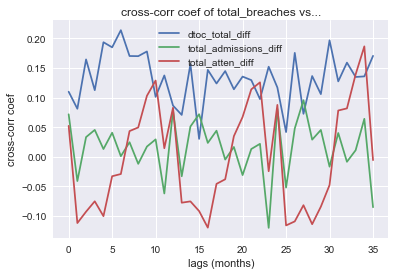

In [21]:
xvars = ['dtoc_total_diff','total_admissions_diff','total_atten_diff']
compute_crosscorr_mult_inputs(df_dtoc,'total_breaches',xvars,36, title='cross-corr coef of total_breaches vs...')

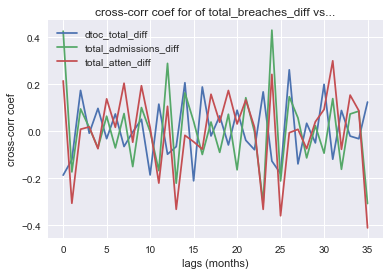

In [22]:
xvars = ['dtoc_total_diff','total_admissions_diff','total_atten_diff']
compute_crosscorr_mult_inputs(df_dtoc,'total_breaches_diff',xvars,36,title='cross-corr coef for of total_breaches_diff vs...')

Autocorrelations

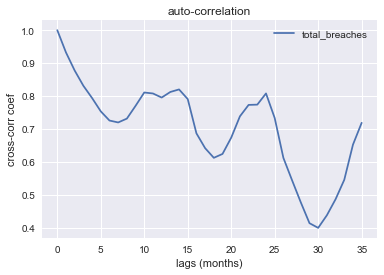

In [23]:
xvars = ['total_breaches']
compute_crosscorr_mult_inputs(df_dtoc,'total_breaches',xvars,36,title='auto-correlation')

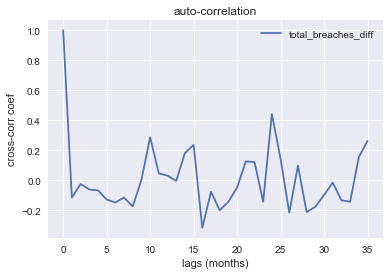

In [24]:
xvars = ['total_breaches_diff']
compute_crosscorr_mult_inputs(df_dtoc,'total_breaches_diff',xvars,36,title='auto-correlation')

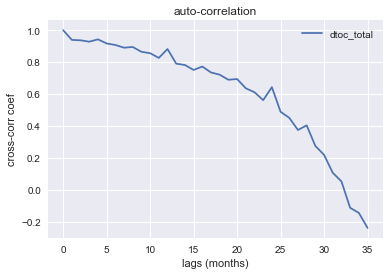

In [25]:
xvars = ['dtoc_total']
compute_crosscorr_mult_inputs(df_dtoc,'dtoc_total',xvars,36,title='auto-correlation')

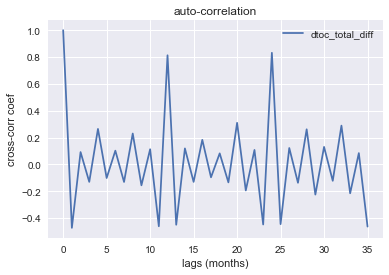

In [26]:
xvars = ['dtoc_total_diff']
compute_crosscorr_mult_inputs(df_dtoc,'dtoc_total_diff',xvars,36,title='auto-correlation')

In [32]:
df_dtoc.columns

Index(['year', 'month', 'total_atten', 'total_atten_t1', 'total_breaches',
       '95%_targ', 'total_admissions', 'dtoc_a', 'dtoc_na', 'dtoc_total',
       'total_breaches_diff', 'dtoc_total_diff', 'total_admissions_diff',
       'total_atten_diff'],
      dtype='object')

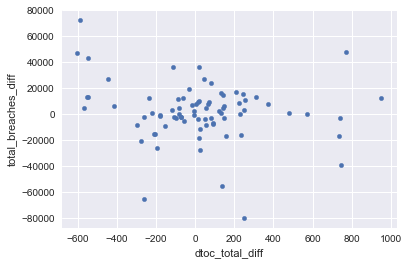

In [31]:
df_dtoc.plot.scatter('dtoc_total_diff','total_breaches_diff')

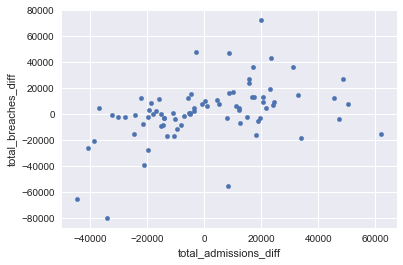

In [33]:
df_dtoc.plot.scatter('total_admissions_diff','total_breaches_diff')

#### Tom stop reading here

In [27]:
break

SyntaxError: 'break' outside loop (<ipython-input-27-6aaf1f276005>, line 1)

In [ ]:
cross_corr_scores[i] = corrs

In [ ]:
cross_corr_scores.plot()

In [ ]:
xcor_monthly = [bk_crosscorr(df_dtoc['total_breaches'], df_dtoc['dtoc_total'], lag=i) for i in range(40)]

In [ ]:
pd.DataFrame(xcor_monthly).plot()

In [ ]:
xcor_monthly = [bk_crosscorr(df_dtoc['total_breaches_diff'], df_dtoc['dtoc_total_diff'], lag=i) for i in range(40)]

In [ ]:
xcor_monthly

In [ ]:
pd.DataFrame(xcor_monthly).plot()

In [ ]:
corr = signal.correlate(breaches_diff.loc[breaches_diff.index > 0], dtoc_total_diff.loc[dtoc_total_diff.index > 0], mode='same')
#corr = corr/np.max(corr)

In [ ]:
corr

In [ ]:
fig, (ax_breaches, ax_dtocs) = plt.subplots(2, 1, sharex=True)
ax_breaches.plot(breaches_diff.loc[breaches_diff.index > 0])
ax_breaches.set_title('Breaches')
ax_dtocs.plot(dtoc_total_diff.loc[dtoc_total_diff.index > 0])
ax_dtocs.set_title('DToCs')
ax_breaches.margins(0, 0.1)
fig.tight_layout()


In [ ]:
fig, ax_corr = plt.subplots(1, 1, sharex=True)
ax_corr.plot(corr)
ax_corr.set_title('Cross-correlation')
ax_corr.set_xlabel('lag')
ax_corr.axhline(0.0, ls=':')

Notes:
Might need to take 2nd difference.

Note sure what you do about interpretation of significance?

# Dev

In [ ]:
a = [1,2,-2,4,2,3,1,0]
b = [2,3,-2,3,2,4,1,-1]
c = [-2,0,4,0,1,1,0,-2]

data = {'a':a,'b':b,'c':c}

In [ ]:
import pandas as pd
%matplotlib inline

In [ ]:
df = pd.DataFrame(data)

In [ ]:
df

In [ ]:
df.plot()

In [ ]:
df.corr()

In [ ]:
df.corr('spearman')

In [ ]:
len(df.a)

In [ ]:
def bk_cov(df1,df2):
    'calc cov from two series'
    X = df1.values
    Xm = df1.values.sum()/len(X)
    Y = df2.values
    Ym = df2.values.sum()/len(Y)
    cov = ( ((X-Xm)*(Y-Ym))/len(Y)).sum()
    return(cov)

In [ ]:
bk_cov(df.a,df.b)

In [ ]:
bk_cov(df.b,df.a)

In [ ]:
np.cov(df.a,df.b)

In [ ]:
def bk_cor(df1,df2):
    'cal corr'
    cor = bk_cov(df1,df2)/np.sqrt(bk_cov(df1,df1) * bk_cov(df2,df2))
    return cor

In [ ]:
bk_cor(df.b,df.c)

In [ ]:
bk_cor(df.a,df.c)

In [ ]:
np.corrcoef(df,rowvar=0)

In [ ]:
def bk_crosscorr(df1,df2,lag=0):
    return bk_cor(df1[lag:],df2.shift(lag)[lag:])

In [ ]:
df.a.shift(1)[1:]

In [ ]:
bk_crosscorr(df.a,df.c)

on DTOC data

In [ ]:
df_dtoc.shape

In [ ]:
df_dtoc.dropna().shape

In [ ]:
df_dtoc.columns

In [ ]:
bk_crosscorr(df_dtoc['total_atten_>4hr'],df_dtoc['dtoc_total'])

In [ ]:
xcor_monthly = [bk_crosscorr(df_dtoc['total_atten_>4hr'], df_dtoc['dtoc_total'], lag=i) for i in range(40)]

In [ ]:
pd.DataFrame(xcor_monthly).plot()

In [ ]:
pd.DataFrame(xcor_monthly).plot()

In [ ]:
from scipy import signal

In [ ]:
corr = signal.correlate(df.a.values,df.b.values, mode='full',method='direct')
#corr = corr/np.max(corr)

In [ ]:
corr

In [ ]:
import numpy as np

In [ ]:
np.correlate(df.a,df.b,mode='valid')

In [ ]:
def bk_cov2(df1,df2):
    'calc cov from two series'
    X = df1.values
    Xm = df1.values.sum()/len(X)
    Y = df2.values
    Ym = df2.values.sum()/len(Y)
    cov =  (((X-Xm)*(Y-Ym))/len(Y))#.sum()
    return(cov)

In [ ]:
bk_cov2(df.a,df.b)

In [ ]:
np.corrcoef(df,rowvar=0)

In [ ]:
np.corrcoef(df.a,df.b,rowvar=0)

In [ ]:
np.cov(df.a,df.b)/(np.sqrt(np.cov(df.a,df.b)*np.cov(df.a,df.a)))

In [ ]:
E(XY)−E(X)E(Y)

In [ ]:
df.a.values

In [ ]:
df.a.values * df.a.values

In [ ]:
df.a.sum()

In [ ]:
import scipy as sp

In [ ]:
sp.corrcoef()

In [ ]:
sp.correlate()

# random noise checks

In [128]:
i = 400

In [129]:
import pandas as pd
from numpy.random import random_sample

make random noise in 2 time signals

In [139]:
rand = pd.DataFrame({'a': random_sample(i),'b':random_sample(i)})

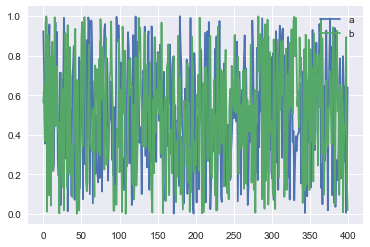

In [140]:
rand.plot()

In [141]:
rand.corr()

,a,b
a,1.000000,-0.005086
b,-0.005086,1.000000


obivously low correlations

add trend to each time series 

In [142]:
rand['a_trend'] = rand.a + rand.index/100

In [143]:
rand['b_trend'] = rand.b + rand.index/50

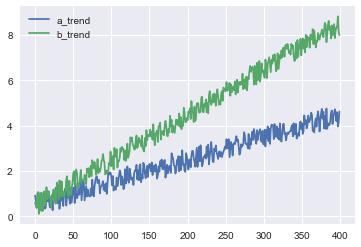

In [144]:
rand[['a_trend','b_trend']].plot()

In [145]:
rand.corr()

,a,b,a_trend,b_trend
a,1.000000,-0.005086,0.184565,-0.056383
b,-0.005086,1.000000,0.041753,0.165359
a_trend,0.184565,0.041753,1.000000,0.963480
b_trend,-0.056383,0.165359,0.963480,1.000000


correaltions huge!

difference time series

In [148]:
rand['a_trend_diff'] = rand.a_trend.diff()
rand['b_trend_diff'] = rand.b_trend.diff()

In [149]:
rand.corr()

,a,b,a_trend,b_trend,a_trend_diff,b_trend_diff
a,1.000000,-0.005086,0.184565,-0.056383,0.700269,0.050345
b,-0.005086,1.000000,0.041753,0.165359,-0.037193,0.708729
a_trend,0.184565,0.041753,1.000000,0.963480,0.174099,0.007663
b_trend,-0.056383,0.165359,0.963480,1.000000,0.001463,0.082513
a_trend_diff,0.700269,-0.037193,0.174099,0.001463,1.000000,0.010960
b_trend_diff,0.050345,0.708729,0.007663,0.082513,0.010960,1.000000


correlations back to reasonable level